# MACD

- 이동평균 수렴 발산
- 빠른 EMA - 느린 EMA
- MACD값 자체에 평활화 지수이동평균을 적용해 MACD지표로부터 최종 시그널 얻음
- 시그널은 추세의 방향, 크기, 지속 기간을 포착

In [1]:
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt

In [2]:
start_date = '2014-01-01'
end_date = '2018-01-01'
SRC_DATA_FILENAME = 'goog_data.pkl'

try:
  goog_data2 = pd.read_pickle(SRC_DATA_FILENAME)
except FileNotFoundError:
  goog_data2 = data.DataReader('GOOG', 'yahoo', start_date, end_date)
  goog_data2.to_pickle(SRC_DATA_FILENAME)

goog_data = goog_data2.tail(620)

close = goog_data['Close']

- 10일 기간의 빠른 EMA와 40일 기간의 느린 EMA, 평활화 팩터를 2/11과 2/41로 각각 EMA에 대한 디폴트 설정

In [3]:
num_periods_fast = 10               # 빠른 EMA를 위한 기간
K_fast = 2 / (num_periods_fast + 1) # 빠른 EMA 평활화 팩터
ema_fast = 0
num_periods_slow = 40               # 느린 EMA를 위한 기간
K_slow = 2 / (num_periods_slow + 1) # 느린 EMA 평활화 팩터
ema_slow = 0
num_periods_macd = 20               # MACD EMA RLRKS
K_macd = 2 / (num_periods_macd + 1) # MACD EMA 평활화 팩터
ema_macd = 0

ema_fast_values = []                # 시각화를 위해 빠른 EMA값 추적
ema_slow_values = []                # 시각화를 위해 느린 EMA값 추적
macd_values = []                    # 시각화를 위해 MACD값 추적
macd_signal_values = []             # MACD EMA값 추적
macd_historgram_values = []         # MACD - MACD-EMA
for close_price in close:
  if (ema_fast == 0):               # 첫 번째 관찰값
    ema_fast = close_price
    ema_slow = close_price
  else:
    ema_fast = (close_price - ema_fast) * K_fast + ema_fast
    ema_slow = (close_price - ema_slow) * K_slow + ema_slow

  ema_fast_values.append(ema_fast)
  ema_slow_values.append(ema_slow)

  macd = ema_fast - ema_slow        # MACD는 빠른 EMA - 느린 EMA
  if ema_macd == 0:
    ema_macd = macd
  else:
    ema_macd = (macd - ema_macd) * K_macd + ema_macd # 시그널은 MACD값의 EMA

  macd_values.append(macd)
  macd_signal_values.append(ema_macd)
  macd_historgram_values.append(macd - ema_macd)

- EMA기간은 20일, 디폴트 평활화 팩터는 2/21

In [4]:
goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(FastExponential10DayMovingAverage=pd.Series(ema_fast_values, index=goog_data.index))
goog_data = goog_data.assign(SlowExponential40DayMovingAverage=pd.Series(ema_slow_values, index=goog_data.index))
goog_data = goog_data.assign(MovingAverageConvergenceDivergence=pd.Series(macd_values, index=goog_data.index))
goog_data = goog_data.assign(Exponential20DayMovingAverageOfMACD=pd.Series(macd_signal_values, index=goog_data.index))
goog_data = goog_data.assign(MACDHistorgram=pd.Series(macd_historgram_values, index=goog_data.index))

close_price = goog_data['ClosePrice']
ema_f = goog_data['FastExponential10DayMovingAverage']
ema_s = goog_data['SlowExponential40DayMovingAverage']
macd = goog_data['MovingAverageConvergenceDivergence']
ema_macd = goog_data['Exponential20DayMovingAverageOfMACD']
macd_histogram = goog_data['MACDHistorgram']


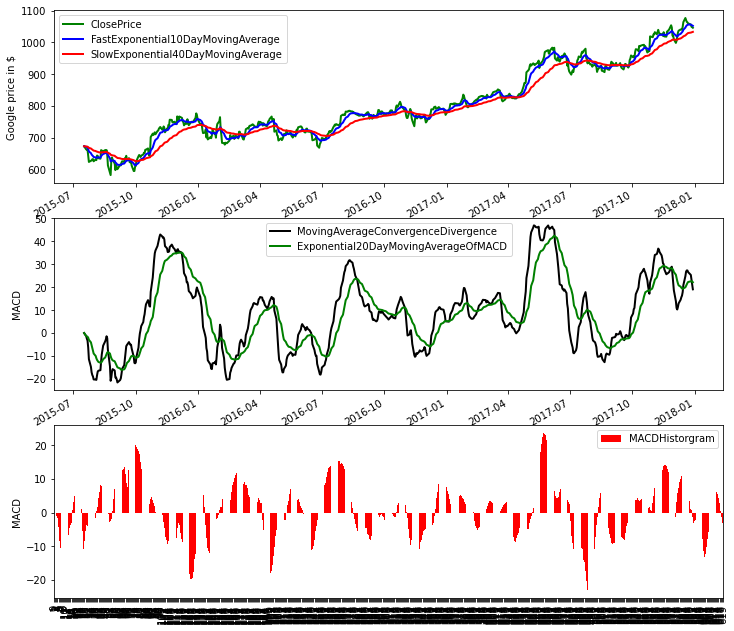

In [6]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(311, ylabel='Google price in $')
close_price.plot(ax=ax1, color='g', lw=2., legend=True)
ema_f.plot(ax=ax1, color='b', lw=2., legend=True)
ema_s.plot(ax=ax1, color='r', lw=2., legend=True)
ax2 = fig.add_subplot(312, ylabel='MACD')
macd.plot(ax=ax2, color='black', lw=2., legend=True)
ema_macd.plot(ax=ax2, color='g', lw=2., legend=True)
ax3 = fig.add_subplot(313, ylabel='MACD')
macd_histogram.plot(ax=ax3, color='r', kind='bar', legend=True, use_index=False)
plt.show()

- MACD 시그널은 APO와 유사
- 그러나 EMA는 추가로 미가공의 MACD에 평활 팩터를 적용한 것이며, 미가공의 MACD 잡음을 평활화함으로써 추세 지속기간을 포착
- MACD는 추세 형성, 전환 시기부호가 전환된 이후 MACD값이 양 또는 음으로 머물 때 지속되는 추세의 크기를 포착